# Sawyer Jacobson
## Data Science Capstone, Midterm Project

Planned things to do:

- Data Preprocessing
    - Fill in missing values
    - Clean the 'target' salary data
    - Split into train and test data
- EDA
    - Plot distributions of variables
        - Games played is pretty big
    - Check for high correlations
    - Potentially look for outliers
    - Separate by position
- Modeling
    - Unsupervised clustering as feature engineering
        - Kmeans separately on forwards and defensemen
        - Used to potentially categorize offensive and defensive players in each group since that is where the clusters will most likely align
    - Potential feature selection since there are a fair amount of features for the number of observations
    - Supervised learning: predicting salary
        - Use and optimize a few different models with RMSE as the error metric


In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn import metrics
import sklearn as sk
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Preprocessing

Here we will read in the data and explore, fill in missing values, and drop redundant variables as needed. The salary dataset will also be cleaned and merged with the player statistics dataset to determine how many observations will be present.

Additionally, we must check for duplicate players on different teams throughout each season to account for trades. These cases will need to be combined to get the players complete statistics for the season. This should be as simple as aggregating numeric variables and leaving others along.

In [2]:
player_df = pd.read_csv("data/player_season.csv")
salary_full = pd.read_csv("data/player_salary.csv")
salary_full.rename(columns = {"player": "fullName"}, inplace = True)
# updating the max seen columns to help see the data
pd.set_option("max_columns", player_df.shape[1])

player_df.head()
salary_full.head()

player_df.shape
salary_full.shape

player_df.isnull().sum()

,position,team,id,fullName,link,firstName,lastName,primaryNumber,birthDate,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,rookie,shootsCatches,season_type,season,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,rosterStatus,goalsInOvertime,goalsTrailingByThreePlus
0,C,New Jersey Devils,8470619,Brian Boyle,/api/v1/people/8470619,Brian,Boyle,9.0,1984-12-18,Hingham,MA,USA,USA,"6' 6""",245,False,False,L,R,20182019,980:48,6,18,38,123,73,145,7,9,192:05,676:00,38,51.05,14.63,4,0,1,2,112:43,50,-14,24,1255,13:26,09:15,01:32,02:37,4.0,6.0,8.0,0.0,1.0,2.0,4.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,R,New Jersey Devils,8471226,Drew Stafford,/api/v1/people/8471226,Drew,Stafford,18.0,1985-10-30,Milwaukee,WI,USA,USA,"6' 2""",215,False,False,R,R,20182019,699:08,8,5,18,77,57,50,1,2,50:26,646:27,18,41.02,6.49,0,0,0,0,02:15,19,-7,13,868,12:15,11:20,00:02,00:53,2.0,3.0,NaN,0.0,2.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,C,New Jersey Devils,8471233,Travis Zajac,/api/v1/people/8471233,Travis,Zajac,14.0,1985-05-13,Winnipeg,MB,CAN,CAN,"6' 2""",185,True,False,R,R,20182019,1541:40,27,19,20,120,80,66,5,12,211:31,1112:40,20,58.16,15.83,3,1,2,2,217:29,38,-25,46,1818,19:16,13:54,02:43,02:38,7.0,8.0,3.0,0.0,0.0,1.0,2.0,1.0,6.0,4.0,2.0,1.0,0.0,0.0,35.0,False,False,Y,1.0,3.0
3,D,New Jersey Devils,8472382,Andy Greene,/api/v1/people/8472382,Andy,Greene,4.0,1982-10-30,Trenton,MI,USA,USA,"5' 11""",190,True,False,L,R,20182019,1708:22,20,5,16,104,82,67,0,2,09:09,1363:18,16,0.00,4.81,0,0,0,4,335:55,208,-9,25,2027,20:50,16:37,04:05,00:06,1.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,38.0,False,False,Y,NaN,2.0
4,D,New Jersey Devils,8473468,Eric Gryba,/api/v1/people/8473468,Eric,Gryba,2.0,1988-04-14,Saskatoon,SK,CAN,CAN,"6' 4""",222,False,False,R,R,20182019,152:57,0,0,10,11,10,21,0,0,00:07,140:09,10,0.00,0.00,0,0,0,0,12:41,16,-1,0,194,15:17,14:00,01:16,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,fullName,position,age,base_salary,signing_bonus,perf_bonus,total_salary,total_cap_hit,adjusted_cap_hit,cap_pct,team,season
0,Aaron Dell,G,29,"$1,950,000","$250,000",-,"$2,200,000","$1,900,000","$1,900,000",2.37,san-jose-sharks,2018/2019
1,Aaron Dell,G,30,"$1,600,000",-,-,"$1,600,000","$1,900,000","$1,900,000",2.62,san-jose-sharks,2019/2020
2,Aaron Ekblad,D,22,"$4,000,000",-,-,"$7,000,000","$7,500,000","$7,500,000",9.76,florida-panthers,2018/2019
3,Aaron Ekblad,D,23,"$5,000,000","$4,000,000",-,"$9,000,000","$7,500,000","$7,500,000",9.38,florida-panthers,2019/2020
4,Adam Boqvist,D,19,"$832,500","$92,500","$850,000","$705,712","$894,167","$658,559",0.95,chicago-blackhawks,2019/2020


(1947, 67)

(1482, 12)

position                       0
team                           0
id                             0
fullName                       0
link                           0
                            ... 
alternateCaptain             242
captain                      242
rosterStatus                 242
goalsInOvertime             1677
goalsTrailingByThreePlus    1371
Length: 67, dtype: int64

In [3]:
# some player names are longer or have slightly different capitalization so I'm
# going to hand fix as many as I can
salary_full.loc[salary_full.fullName == "Cameron Atkinson", ['fullName']] = "Cam Atkinson"
salary_full.loc[salary_full.fullName == "Alexander Debrincat", ['fullName']] = "Alex DeBrincat"
salary_full.loc[salary_full.fullName == "Alexander Killorn", ['fullName']] = "Alex Killorn"
salary_full.loc[salary_full.fullName == "Charles Mcavoy", ['fullName']] = "Charlie McAvoy"
salary_full.loc[salary_full.fullName == "Chris Tanev", ['fullName']] = "Christopher Tanev"
salary_full.loc[salary_full.fullName == "Dylan Demelo", ['fullName']] = "Dylan DeMelo"

salary_full.loc[salary_full.fullName == "Evgeni Dadonov", ['fullName']] = "Evgenii Dadonov"
salary_full.loc[salary_full.fullName == "Gabe Vilardi", ['fullName']] = "Gabriel Vilardi"
salary_full.loc[salary_full.fullName == "Gaëtan Haas", ['fullName']] = "Gaetan Haas"
salary_full.loc[salary_full.fullName == "J.T Compher", ['fullName']] = "J.T. Compher"
salary_full.loc[salary_full.fullName == "J.T. Brown", ['fullName']] = "JT Brown"
salary_full.loc[salary_full.fullName == "Jacob De La Rose", ['fullName']] = "Jacob de la Rose"
salary_full.loc[salary_full.fullName == "Jacob Muzzin", ['fullName']] = "Jake Muzzin"
salary_full.loc[salary_full.fullName == "James Van Riemsdyk", ['fullName']] = "James van Riemsdyk"

salary_full.loc[salary_full.fullName == "Joshua Brown", ['fullName']] = "Josh Brown"
salary_full.loc[salary_full.fullName == "Joshua Morrissey", ['fullName']] = "Josh Morrissey"
salary_full.loc[salary_full.fullName == "Kenneth Agostino", ['fullName']] = "Kenny Agostino"
salary_full.loc[salary_full.fullName == "Kurtis Macdermid", ['fullName']] = "Kurtis MacDermid"
salary_full.loc[salary_full.fullName == "MacKenzie MacEachern", ['fullName']] = "Mackenzie MacEachern"
salary_full.loc[salary_full.fullName == "Magnus Paajarvi-Svensson", ['fullName']] = "Magnus Paajarvi"
salary_full.loc[salary_full.fullName == "Mats Zuccarello-Aasen", ['fullName']] = "Mats Zuccarello"
salary_full.loc[salary_full.fullName == "Matthew Benning", ['fullName']] = "Matt Benning"
salary_full.loc[salary_full.fullName == "Matthew Grzelcyk", ['fullName']] = "Matt Grzelcyk"
salary_full.loc[salary_full.fullName == "Michael Matheson", ['fullName']] = "Mike Matheson"

salary_full.loc[salary_full.fullName == "Michael Mcleod", ['fullName']] = "Michael McLeod"
salary_full.loc[salary_full.fullName == "Nicholas Paul", ['fullName']] = "Nick Paul"
salary_full.loc[salary_full.fullName == "Nicholas Ritchie", ['fullName']] = "Nick Ritchie"
salary_full.loc[salary_full.fullName == "Nick Shore", ['fullName']] = "Nicholas Shore"
salary_full.loc[salary_full.fullName == "Nicolas Petan", ['fullName']] = "Nic Petan"
salary_full.loc[salary_full.fullName == "Nikolay Prokhorkin", ['fullName']] = "Nikolai Prokhorkin"
salary_full.loc[salary_full.fullName == "Patrick Maroon", ['fullName']] = "Pat Maroon"
salary_full.loc[salary_full.fullName == "Paul Ladue", ['fullName']] = "Paul LaDue"
salary_full.loc[salary_full.fullName == "Philip Kessel", ['fullName']] = "Phil Kessel"
salary_full.loc[salary_full.fullName == "Phillip di Giuseppe", ['fullName']] = "Phillip Di Giuseppe"

salary_full.loc[salary_full.fullName == "Samuel Blais", ['fullName']] = "Sammy Blais"
salary_full.loc[salary_full.fullName == "T.J. Brodie", ['fullName']] = "TJ Brodie"
salary_full.loc[salary_full.fullName == "Theodor Blueger", ['fullName']] = "Teddy Blueger"
salary_full.loc[salary_full.fullName == "Thomas Wilson", ['fullName']] = "Tom Wilson"
salary_full.loc[salary_full.fullName == "Trevor Van Riemsdyk", ['fullName']] = "Trevor van Riemsdyk"
salary_full.loc[salary_full.fullName == "Vincent Hinostroza", ['fullName']] = "Vinnie Hinostroza"
salary_full.loc[salary_full.fullName == "Zachary Werenski", ['fullName']] = "Zach Werenski"

In [4]:
# removing unneeded columns and cleaning the salary columns
def clean_money(x):
    return x.str.replace("$", '').str.replace(",", '').str.replace("-", "0")
money_cols = ['base_salary', 'signing_bonus', 'perf_bonus', 'total_salary', 'total_cap_hit']

salary_full[money_cols] = salary_full[money_cols].apply(clean_money).astype(int)/1e6
salary_df = (salary_full.
             query("total_cap_hit != '-'").
             assign(
                 total_salary = lambda x: x.base_salary + x.signing_bonus + x.perf_bonus,
                 season = lambda x: x.season.str.replace("/", '')
             ).
             filter(['fullName', 'total_salary', 'total_cap_hit', 'season'])
            )
# salary_df.isnull().sum()

salary_df.head()
salary_df.describe()

<ipython-input-4-77c994351adb>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,fullName,total_salary,total_cap_hit,season
0,Aaron Dell,2.200,1.900000,20182019
1,Aaron Dell,1.600,1.900000,20192020
2,Aaron Ekblad,4.000,7.500000,20182019
3,Aaron Ekblad,9.000,7.500000,20192020
4,Adam Boqvist,1.775,0.894167,20192020


,total_salary,total_cap_hit
count,1482.000000,1482.000000
mean,3.226768,2.975673
std,2.696134,2.424949
min,0.650000,0.000000
25%,0.925000,0.894166
50%,2.337500,2.100000
75%,5.000000,4.833333
max,16.000000,12.500000


In [5]:
pd.set_option("max_info_columns", player_df.shape[1])
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   position                     1947 non-null   object 
 1   team                         1947 non-null   object 
 2   id                           1947 non-null   int64  
 3   fullName                     1947 non-null   object 
 4   link                         1947 non-null   object 
 5   firstName                    1947 non-null   object 
 6   lastName                     1947 non-null   object 
 7   primaryNumber                1944 non-null   float64
 8   birthDate                    1947 non-null   object 
 9   birthCity                    1947 non-null   object 
 10  birthStateProvince           1393 non-null   object 
 11  birthCountry                 1947 non-null   object 
 12  nationality                  1947 non-null   object 
 13  height            

In [6]:
# converting the time on ice columns to just minutes, removing the seconds after the : since
# those can be considered negligible in most cases

# function to clean the time on ice from minutes:seconds format to a decimal
def clean_toi(x):
    time = x.str.split(":")
    minutes = time.str.get(0)
    seconds = time.str.get(1).astype(int)*100/60
    return minutes + "." + seconds.round().astype(int).astype(str)

time_on_ice_cols = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce', 'shortHandedTimeOnIce', 
                    'timeOnIcePerGame', 'evenTimeOnIcePerGame', 'shortHandedTimeOnIcePerGame', 
                    'powerPlayTimeOnIcePerGame']
# this isn't working quite right...
player_df[time_on_ice_cols] = player_df[time_on_ice_cols].apply(clean_toi).astype(float)

In [7]:
player_df['season'] = player_df['season'].astype(str)

# converting height to inches
r = re.compile(r"([0-9]+)' ([0-9]*\.?[0-9]+)\"")
def get_inches(height):
    m = r.match(height)
    if m == None:
        return float('NaN')
    else:
        return int(m.group(1))*12 + float(m.group(2))
    
player_df['height'] = player_df['height'].apply(get_inches)

In [8]:
# Setting the currentAge for a season to the general start date of the season - players birthdate
# rounded down

player_df['currentAge'] = np.floor((pd.to_datetime(player_df.season.str.slice(0, 4) + "-10-31") - pd.to_datetime(player_df.birthDate)).dt.days/365.25)

In [9]:
# dropping unnecessary columns
player_final = player_df.drop(columns = ['team', "nationality", "primaryNumber", 'birthDate', 'id', 'link', 'firstName', "lastName", 
                         'birthCity', 'birthStateProvince', 'birthCountry',
                         'active', 'rosterStatus', 'season_type']).copy()
# making the rookie column an integer
player_final["rookie"] = player_final.rookie.astype(int)

In [10]:
# changing missing values to false and making integers for the captain columns
player_final['alternateCaptain'] = player_final.alternateCaptain.fillna("False").astype(bool).astype(int)
player_final['captain'] = player_final.captain.fillna("False").astype(bool).astype(int)

In [11]:
# checking which observations are duplicates
player_final_key = player_final.groupby(by = ['fullName', 'season']).cumcount() == 0
# filtering out the duplicates
player_clean = player_final[player_final_key].reset_index(drop=True).fillna(0)
# need to get matching data for the object columns to merge back in
# straight forward since they are values that won't change in a season
player_clean

,position,fullName,height,weight,rookie,shootsCatches,season,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
0,C,Brian Boyle,78.0,245,0,L,20182019,980.80,6,18,38,123,73,145,7,9,192.80,676.00,38,51.05,14.63,4,0,1,2,112.72,50,-14,24,1255,13.43,9.25,1.53,2.62,4.0,6.0,8.0,0.0,1.0,2.0,4.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,33.0,1,1,0.0,0.0
1,R,Drew Stafford,74.0,215,0,R,20182019,699.13,8,5,18,77,57,50,1,2,50.43,646.45,18,41.02,6.49,0,0,0,0,2.25,19,-7,13,868,12.25,11.33,0.30,0.88,2.0,3.0,0.0,0.0,2.0,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,33.0,1,1,0.0,0.0
2,C,Travis Zajac,74.0,185,0,R,20182019,1541.67,27,19,20,120,80,66,5,12,211.52,1112.67,20,58.16,15.83,3,1,2,2,217.48,38,-25,46,1818,19.27,13.90,2.72,2.63,7.0,8.0,3.0,0.0,0.0,1.0,2.0,1.0,6.0,4.0,2.0,1.0,0.0,0.0,33.0,0,0,1.0,3.0
3,D,Andy Greene,71.0,190,0,L,20182019,1708.37,20,5,16,104,82,67,0,2,9.15,1363.30,16,0.00,4.81,0,0,0,4,335.92,208,-9,25,2027,20.83,16.62,4.80,0.10,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,36.0,0,0,0.0,2.0
4,D,Eric Gryba,76.0,222,0,R,20182019,152.95,0,0,10,11,10,21,0,0,0.12,140.15,10,0.00,0.00,0,0,0,0,12.68,16,-1,0,194,15.28,14.00,1.27,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,C,Nicolas Roy,76.0,205,0,R,20192020,320.20,5,5,8,42,28,39,1,1,2.72,302.13,8,48.18,11.90,1,0,0,0,15.17,7,3,10,439,11.42,10.78,0.53,0.80,3.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,22.0,0,0,0.0,0.0
1785,C,Gage Quinney,71.0,200,1,L,20192020,29.13,1,0,0,2,3,2,0,0,0.00,29.13,0,47.05,0.00,0,0,0,0,0.00,0,-1,1,42,9.70,9.70,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0,0,0.0,0.0
1786,D,Nicolas Hague,78.0,230,0,L,20192020,611.40,10,1,32,54,38,69,1,4,34.73,575.72,32,0.00,1.90,0,0,0,0,0.95,26,0,11,802,16.80,15.15,0.20,0.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20.0,0,0,0.0,0.0
1787,C,Cody Glass,75.0,206,0,R,20192020,521.50,7,5,6,51,39,15,1,6,86.83,433.20,6,41.95,9.80,1,0,0,0,1.20,6,-7,12,627,13.35,11.10,0.20,2.22,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,20.0,0,0,0.0,0.0


In [12]:
player_full = pd.merge(
    salary_df,
    player_clean, 
    on = ['fullName', "season"], 
    how = "inner")

In [13]:
# checking for nulls one last time
# all clear!
player_full.isnull().sum()

fullName                       0
total_salary                   0
total_cap_hit                  0
season                         0
position                       0
height                         0
weight                         0
rookie                         0
shootsCatches                  0
timeOnIce                      0
assists                        0
goals                          0
pim                            0
shots                          0
games                          0
hits                           0
powerPlayGoals                 0
powerPlayPoints                0
powerPlayTimeOnIce             0
evenTimeOnIce                  0
penaltyMinutes                 0
faceOffPct                     0
shotPct                        0
gameWinningGoals               0
overTimeGoals                  0
shortHandedGoals               0
shortHandedPoints              0
shortHandedTimeOnIce           0
blocked                        0
plusMinus                      0
points    

In [14]:
player_full.position.value_counts()

D    476
C    415
L    261
R    173
Name: position, dtype: int64

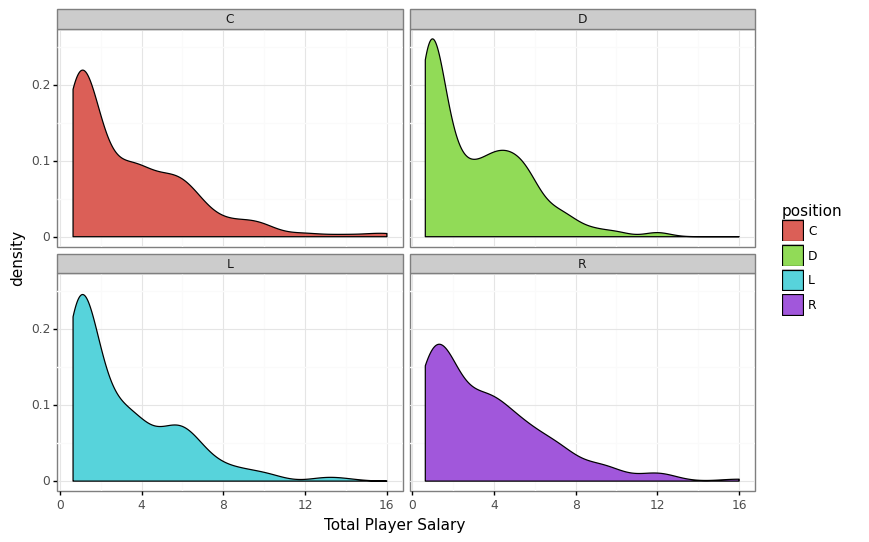

<ggplot: (345574114)>

In [15]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "total_salary", fill = "position")) + 
    geom_density() + 
    theme_bw() + 
    labs(x = "Total Player Salary") +
    facet_wrap(" ~ position")
)

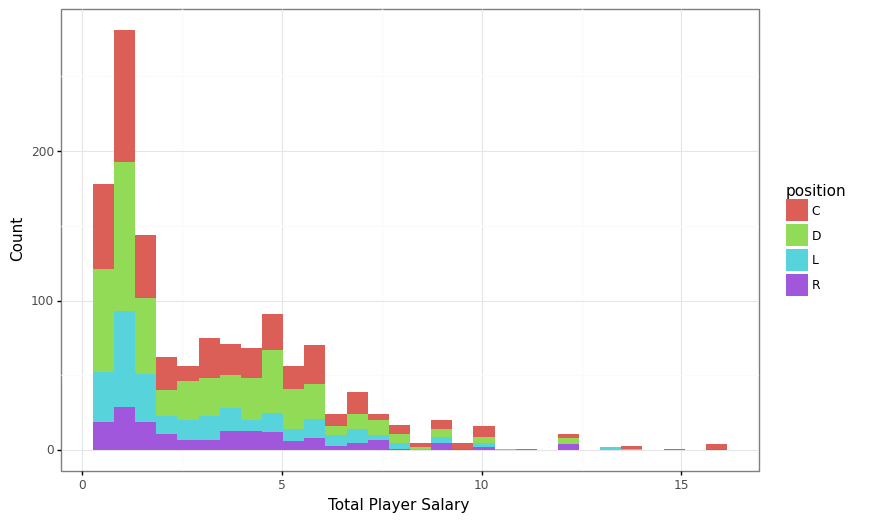

<ggplot: (345684426)>

In [16]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "total_salary", fill = "position")) + 
    geom_histogram(bins = 30) + 
    theme_bw() + 
    labs(x = "Total Player Salary", y = "Count") 
)

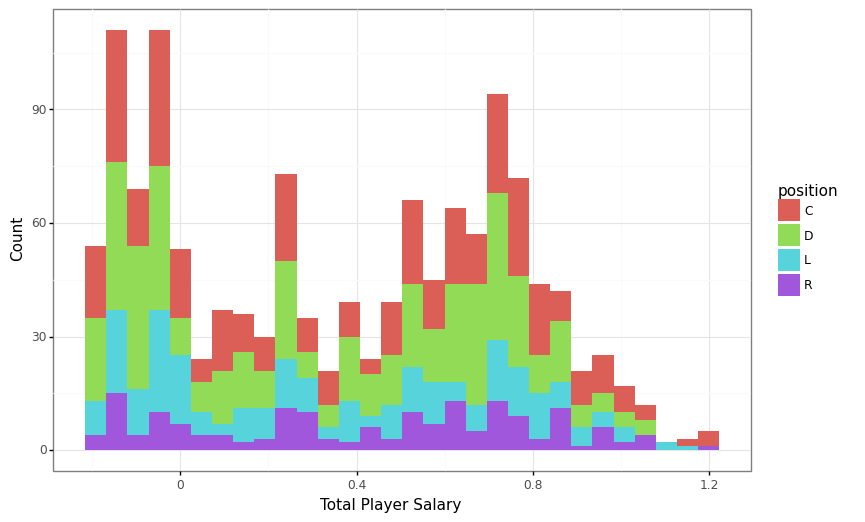

<ggplot: (345923774)>

In [17]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full.assign(log10_sal = np.log10(player_full.total_salary)), mapping = aes(x = "log10_sal", fill = "position")) + 
    geom_histogram(bins = 30) + 
    theme_bw() + 
    labs(x = "Total Player Salary", y = "Count") 
)

In [18]:
player_full[['fullName', 'total_salary', "total_cap_hit"]].describe()
player_full.query('total_cap_hit < 500000')

,total_salary,total_cap_hit
count,1325.000000,1325.000000
mean,3.246928,2.986098
std,2.705869,2.435503
min,0.650000,0.000000
25%,0.925000,0.894166
50%,2.350000,2.100000
75%,5.000000,4.850000
max,16.000000,12.500000


,fullName,total_salary,total_cap_hit,season,position,height,weight,rookie,shootsCatches,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
0,Aaron Ekblad,4.000,7.500000,20182019,D,76.0,215,0,R,1938.82,24,13,47,180,82,114,5,10,139.28,1610.80,47,0.00,7.22,1,1,0,0,188.73,88,1,37,2468,23.63,19.63,2.30,1.68,5.0,5.0,2.0,0.0,0.0,0.0,5.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,22.0,1,0,1.0,0.0
1,Aaron Ekblad,9.000,7.500000,20192020,D,76.0,215,0,R,1539.42,36,5,26,147,67,34,0,6,96.78,1306.48,26,0.00,3.40,1,1,0,1,136.15,84,12,41,1838,22.97,19.48,2.20,1.43,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,23.0,1,0,1.0,1.0
2,Adam Boqvist,1.775,0.894167,20192020,D,71.0,179,0,R,665.12,9,4,6,50,41,33,0,2,88.98,575.45,6,0.00,8.00,1,0,0,0,0.68,43,-3,13,805,16.22,14.30,0.20,2.17,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,19.0,0,0,0.0,0.0
3,Adam Erne,0.800,0.800000,20182019,L,73.0,212,0,L,685.63,13,7,40,70,65,159,2,2,33.20,633.37,40,47.82,10.00,3,0,0,0,19.25,26,10,20,976,10.53,9.73,0.28,0.50,0.0,4.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,23.0,0,0,0.0,1.0
4,Adam Erne,1.050,1.050000,20192020,L,73.0,212,0,L,661.68,3,2,28,63,56,142,0,0,48.62,610.43,28,60.60,3.20,0,0,0,0,2.63,25,-24,5,902,11.80,10.90,0.30,0.87,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,Zack Smith,3.250,3.250000,20192020,C,74.0,208,0,L,589.33,7,4,29,43,50,112,0,0,8.75,518.95,29,46.31,9.30,1,0,1,2,61.63,18,2,11,809,11.78,10.37,1.22,0.17,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,31.0,0,0,0.0,0.0
1321,Zdeno Chara,6.750,5.000000,20182019,D,81.0,250,0,L,1306.82,9,5,57,99,62,81,1,3,4.85,1112.88,57,0.00,5.05,2,0,0,0,189.80,88,22,14,1515,21.70,17.93,3.30,0.70,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,41.0,0,0,0.0,0.0
1322,Zdeno Chara,3.750,2.000000,20192020,D,81.0,250,0,L,1428.73,9,5,60,86,68,78,0,0,3.60,1209.10,60,0.00,5.80,2,0,0,0,216.30,101,26,14,1665,21.00,17.77,3.17,0.50,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,42.0,0,0,0.0,0.0
1323,Zemgus Girgensons,1.600,1.600000,20182019,L,74.0,213,0,L,980.20,13,5,17,78,72,144,0,0,5.73,801.32,17,40.58,6.41,0,0,0,0,172.97,29,-11,18,1306,13.60,11.12,2.40,0.70,2.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,24.0,0,0,0.0,1.0


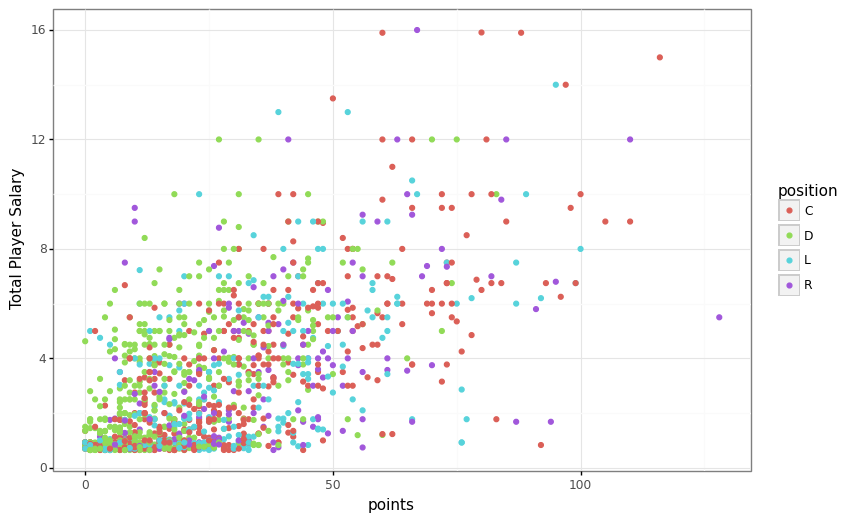

<ggplot: (345964996)>

In [19]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full.assign(points = player_full.goals + player_full.assists), mapping = aes(x = "points", y = "total_salary", color = "position")) + 
    geom_point() + 
    theme_bw() + 
    labs(y = "Total Player Salary", x = "points")
)

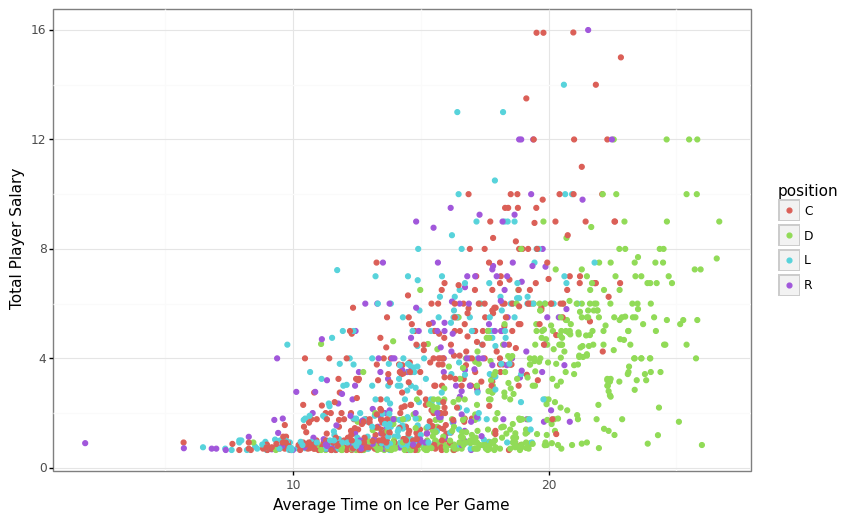

<ggplot: (345709252)>

In [20]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "timeOnIcePerGame", y = "total_salary", color = "position")) + 
    geom_point() + 
    theme_bw() + 
    labs(y = "Total Player Salary", x = "Average Time on Ice Per Game")
)

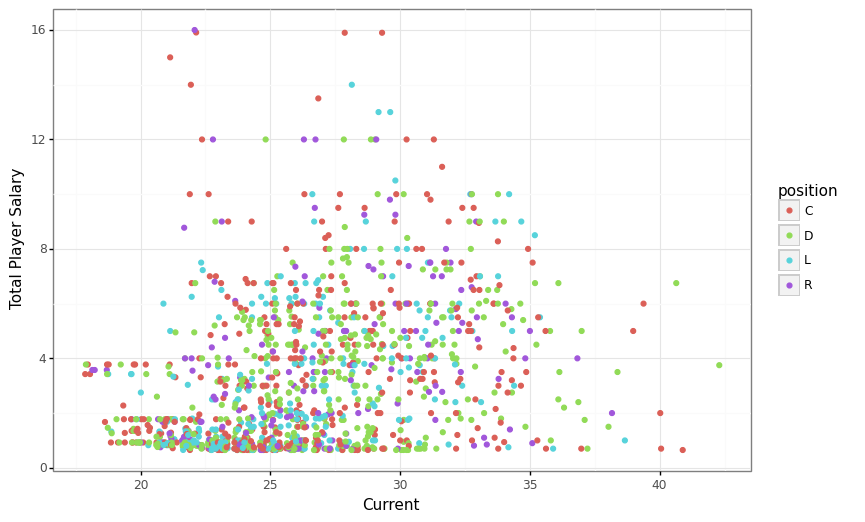

<ggplot: (345922639)>

In [21]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "currentAge", y = "total_salary", color = "position")) + 
    geom_jitter() + 
    theme_bw() + 
    labs(y = "Total Player Salary", x = "Current")
)

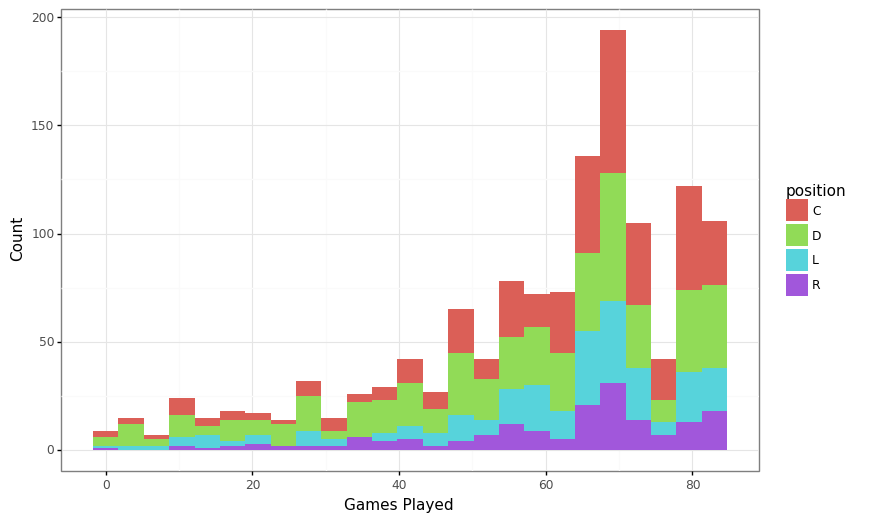

<ggplot: (345966270)>

In [22]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full, mapping = aes(x = "games", fill = "position")) + 
    geom_histogram(bins = 25) + 
    theme_bw() + 
    labs(x = "Games Played", y = "Count")
)

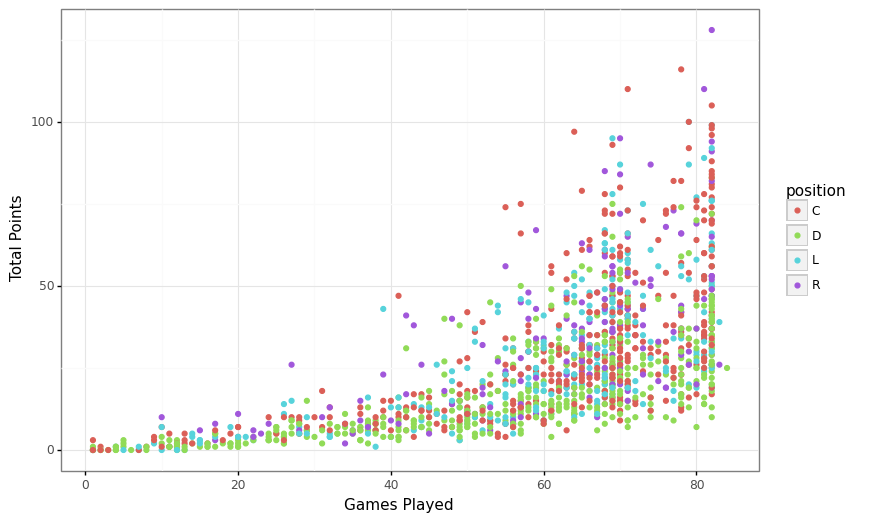

<ggplot: (345957928)>

In [23]:
plotnine.options.figure_size = (9, 6)

(
ggplot(data = player_full.assign(points = player_full.goals + player_full.assists), mapping = aes(x = "games", y = "points", color = "position")) + 
    geom_point() + 
    theme_bw() + 
    labs(x = "Games Played", y = "Total Points")
)

## Prepping pipelines for modeling

# Model Fitting

First we will do some cluster analyses to try to tease out distinct clusters in the forwards and defensemen. Theorically these should be more offensively/defensively inclined. These will then be used in the models for predictions as well as plotted with some PCA variables to see how the clustering worked.# columns for one-hot-encoding

In [24]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

salary_data = player_full[['total_cap_hit', 'total_salary']].copy()

# dropping some columns that should not be used in the X data
# goals, for instance, is captured through the different goalsIn.. variables
X_full = player_full.drop(columns = ['total_cap_hit', 'total_salary', 
                                     'fullName', 'season', 'goals', "timeOnIce", "rookie"]).copy()


<AxesSubplot:>

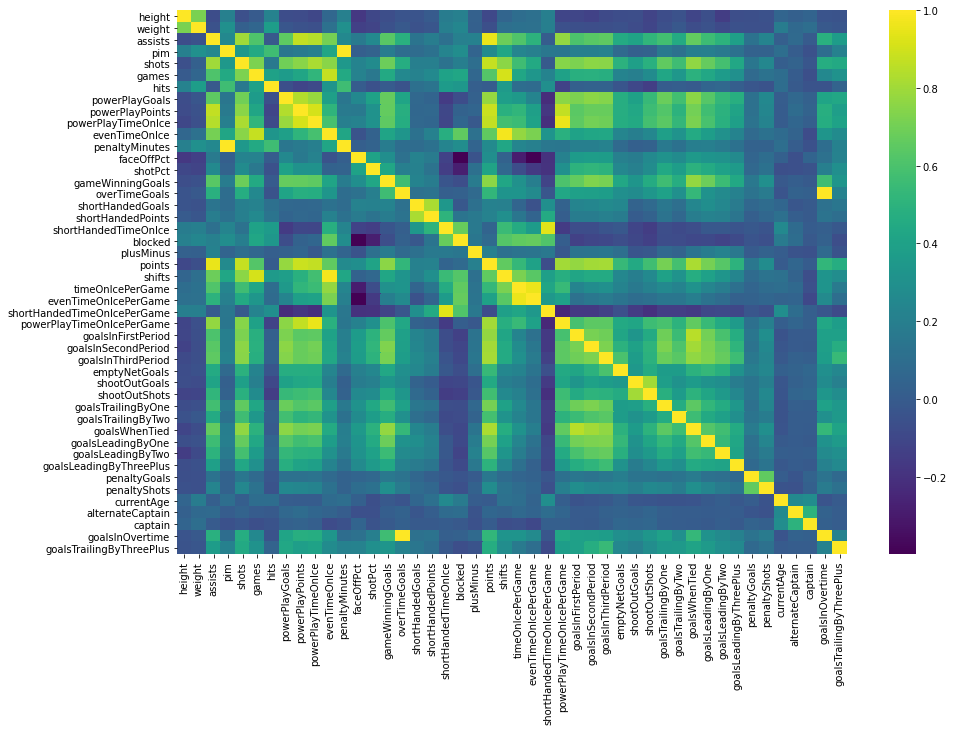

In [25]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(X_full.corr(), ax = ax, cmap = "viridis")

In [26]:
# split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_full, salary_data.total_salary, test_size=.3, random_state=42)

print("X Train shape:", X_train.shape)
print("X Test shape:", X_test.shape)
print("y Train shape:", y_train.shape)
print("y Test shape:", y_test.shape)

X Train shape: (927, 48)
X Test shape: (398, 48)
y Train shape: (927,)
y Test shape: (398,)


In [27]:
# separating forwards and defensemen for cluster analysis 
forwards = (
    X_train[X_train.position.isin(["R", "L", "C"])].
#     drop(columns = ['fullName', 'season', "total_salary", "total_cap_hit"]).
    copy()
)

defense = (
    X_train[X_train.position == "D"].
#     drop(columns = ['fullName', 'season', "total_salary", "total_cap_hit"]).
    copy()
)


# selecting only the columns that are offensively related so that some performance 
# differences will ideally be focused on performance
forward_offence = forwards.filter(regex="games|goals|assists|plus|shots")
defense_offence = defense.filter(regex="games|goals|assists|plus|shots")

# instantiate and create Kmeans clusters for both the forwards and defensemen
from sklearn.cluster import KMeans

km_for = KMeans(n_clusters=3, random_state=42)
km_def = KMeans(n_clusters=3, random_state=42)

# storing the clusters
forwards['km_clust'] = km_for.fit_predict(forward_offence)

defense['km_clust'] = km_def.fit_predict(defense_offence) + 3

X_train = pd.concat([forwards, defense], axis='index', ignore_index=True)
X_train.head()
X_train.km_clust.value_counts()

,position,height,weight,shootsCatches,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus,km_clust
0,L,75.0,212,L,12,12,112,55,88,12,17,158.83,736.80,12,35.48,17.00,2,0,0,0,1.27,17,-20,31,1006,16.30,13.38,0.20,2.88,7.0,6.0,6.0,0.0,0.0,0.0,3.0,3.0,6.0,2.0,2.0,2.0,0.0,0.0,32.0,0,0,0.0,1.0,2
1,L,74.0,205,L,34,64,174,82,115,2,9,188.55,1249.47,64,43.45,15.52,5,1,0,0,14.65,52,16,61,1820,17.70,15.23,0.17,2.28,11.0,6.0,9.0,1.0,1.0,1.0,4.0,2.0,11.0,6.0,2.0,2.0,0.0,0.0,20.0,0,0,1.0,0.0,0
2,R,68.0,176,R,14,6,148,44,18,3,8,100.35,615.37,6,47.36,8.10,2,1,0,0,69.47,21,2,26,1019,17.83,13.98,1.57,2.27,6.0,3.0,2.0,1.0,0.0,1.0,2.0,1.0,6.0,2.0,1.0,0.0,0.0,0.0,30.0,0,0,1.0,0.0,2
3,C,75.0,195,L,2,2,36,54,59,0,0,1.32,493.72,2,42.47,5.60,0,0,0,0,67.12,18,-21,4,758,10.40,9.13,1.23,0.20,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,1,1,0.0,0.0,1
4,C,73.0,195,L,19,24,105,81,28,0,1,26.33,1085.22,24,38.46,5.71,0,0,0,1,120.98,44,-4,25,1774,15.20,13.38,1.48,0.32,0.0,4.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,25.0,0,0,0.0,0.0,2


2    250
1    206
3    160
0    134
5    124
4     53
Name: km_clust, dtype: int64

In [28]:
# use PCA to visualize some of the clusters
from sklearn.decomposition import PCA

# initiating classes
pca_for = PCA(n_components=2)
pca_def = PCA(n_components=2)

# creating a dataset that will only have the clusters and the PCA variables in it
for_clust = pd.DataFrame(forwards.km_clust.astype(str))
def_clust = pd.DataFrame(defense.km_clust.astype(str))

pca_for.fit(forward_offence)
pca_def.fit(defense_offence)

pca_cols = ["pca_" + str(i) for i in range(pca_for.n_components_)]

# adding the PCA transformations to the dataframes
for_clust[pca_cols] = pca_for.transform(forward_offence)
def_clust[pca_cols] = pca_def.transform(defense_offence)

PCA(n_components=2)

PCA(n_components=2)

In [29]:
forwards.groupby('km_clust').median()

defense.groupby('km_clust').median()

,height,weight,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
km_clust,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.0,198.0,32.5,28.0,203.0,73.0,55.0,6.0,16.0,202.965,1116.170,28.0,46.150,12.265,4.0,1.0,0.0,0.0,28.275,32.5,1.0,59.0,1670.5,18.670,15.22,0.500,2.830,7.5,8.5,8.0,1.0,1.0,3.0,4.0,2.0,9.0,5.0,3.0,1.0,0.0,0.0,26.0,0.0,0.0,1.0,1.0
1,73.0,198.0,5.5,14.0,50.5,47.0,52.0,0.0,0.0,5.265,474.915,14.0,44.160,9.030,1.0,0.0,0.0,0.0,8.835,19.0,-2.0,10.0,736.0,11.650,10.47,0.500,0.500,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0
2,73.0,198.0,17.0,23.0,120.0,69.0,68.0,2.0,5.0,106.560,875.625,23.0,44.795,10.600,2.0,0.0,0.0,0.0,45.650,30.0,-1.0,31.0,1362.5,15.285,12.83,0.715,1.625,4.0,5.0,4.0,0.0,0.0,0.0,2.0,1.0,4.0,2.0,1.0,1.0,0.0,0.0,26.0,0.0,0.0,0.0,1.0


,height,weight,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus
km_clust,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,73.5,205.0,14.5,27.0,96.0,68.0,81.0,0.0,1.0,20.385,1138.990,27.0,0.0,4.35,0.0,0.0,0.0,0.0,118.18,88.0,1.0,19.0,1605.0,19.46,16.91,1.80,0.70,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0
4,75.0,215.0,28.0,34.0,170.0,78.0,75.0,3.0,11.0,171.900,1380.330,34.0,0.0,5.48,2.0,0.0,0.0,1.0,144.85,108.0,2.0,41.0,1972.0,23.30,18.82,2.12,2.65,2.0,3.0,3.0,0.0,0.0,0.0,2.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0
5,74.0,202.0,5.0,13.5,38.0,37.0,38.0,0.0,0.0,1.420,509.285,13.5,0.0,2.60,0.0,0.0,0.0,0.0,34.40,38.5,-1.0,6.0,735.0,15.55,14.19,1.18,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0


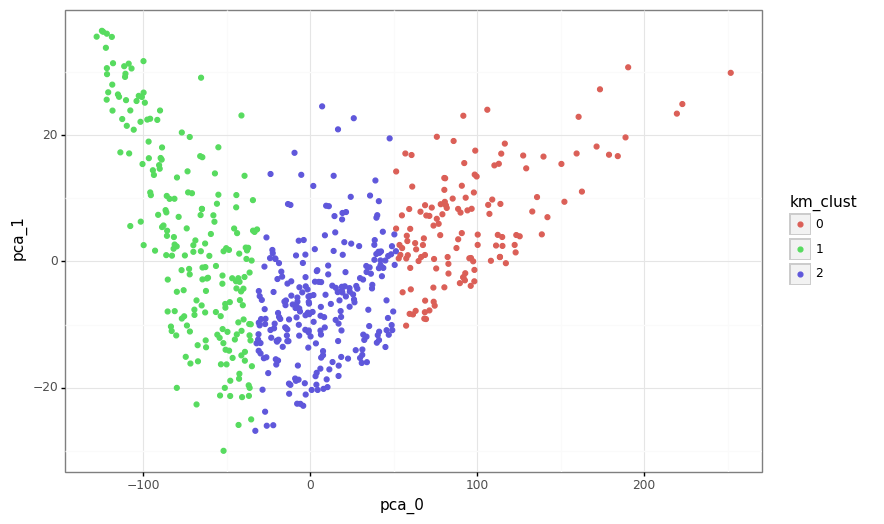

<ggplot: (345751333)>

In [30]:
(
ggplot(for_clust, aes(x = "pca_0", y = "pca_1", color = "km_clust")) + 
    geom_point() + 
    theme_bw()
)

Clusters don't exactly look great... No clear distancing in them, but that is not unexpected

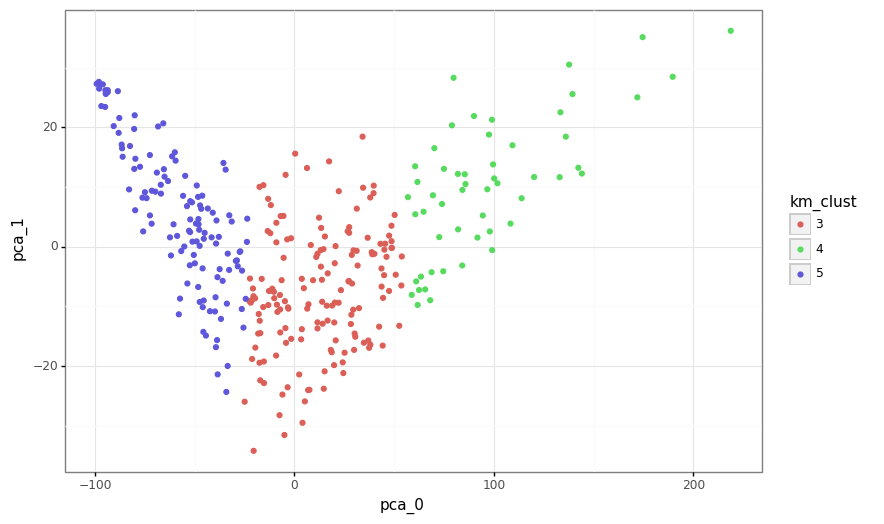

<ggplot: (348949155)>

In [31]:
(
ggplot(def_clust, aes(x = "pca_0", y = "pca_1", color = "km_clust")) + 
    geom_point() + 
    theme_bw()
)

In [32]:
pca_for.explained_variance_ratio_

array([0.92467028, 0.03271344])

In [33]:
for_clust.km_clust.value_counts()
def_clust.km_clust.value_counts()

2    250
1    206
0    134
Name: km_clust, dtype: int64

3    160
5    124
4     53
Name: km_clust, dtype: int64

In [34]:
forwards.shape
defense.shape
X_train.shape

(590, 49)

(337, 49)

(927, 49)

# Model fitting for predictions

In [35]:
# importing models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor

# bringing in model selection tools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# adding trained clustering to the test set

# separating forwards and defensemen for cluster analysis 
forwards_test = (
    X_test[X_test.position.isin(["R", "L", "C"])].
#     drop(columns = ['fullName', 'season', "total_salary", "total_cap_hit"]).
    copy()
)

defense_test = (
    X_test[X_test.position == "D"].
#     drop(columns = ['fullName', 'season', "total_salary", "total_cap_hit"]).
    copy()
)


# selecting only the columns that are offensively related so that some performance 
# differences will ideally be focused on performance
forward_offence_test = forwards_test.filter(regex="games|goals|assists|plus|shots")
defense_offence_test = defense_test.filter(regex="games|goals|assists|plus|shots")

# instantiate and create Kmeans clusters for both the forwards and defensemen
from sklearn.cluster import KMeans

# storing the clusters
forwards_test['km_clust'] = km_for.predict(forward_offence_test)

defense_test['km_clust'] = km_def.predict(defense_offence_test) + 3

X_test = pd.concat([forwards_test, defense_test], axis='index', ignore_index=True)
X_test.head()
X_test.km_clust.value_counts()

,position,height,weight,shootsCatches,assists,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,goalsInFirstPeriod,goalsInSecondPeriod,goalsInThirdPeriod,emptyNetGoals,shootOutGoals,shootOutShots,goalsTrailingByOne,goalsTrailingByTwo,goalsWhenTied,goalsLeadingByOne,goalsLeadingByTwo,goalsLeadingByThreePlus,penaltyGoals,penaltyShots,currentAge,alternateCaptain,captain,goalsInOvertime,goalsTrailingByThreePlus,km_clust
0,L,74.0,195,L,14,91,159,63,97,1,3,76.18,786.28,91,0.00,6.29,1,0,0,0,0.27,27,-10,24,1113,13.68,12.47,0.00,1.20,3.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,0.0,1.0,0.0,0.0,23.0,1,0,0.0,1.0,2
1,L,75.0,231,L,14,91,74,79,259,2,4,106.12,939.52,91,55.55,8.11,0,0,0,0,0.00,22,-9,20,1422,13.23,11.88,0.00,1.33,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,30.0,0,0,0.0,1.0,1
2,L,71.0,180,L,16,24,92,62,56,1,4,110.62,743.98,24,53.84,7.61,1,0,0,0,0.00,28,-14,23,1128,13.78,11.98,0.00,1.78,3.0,0.0,4.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,24.0,1,1,0.0,0.0,2
3,C,71.0,185,R,63,24,229,82,28,2,23,288.40,1328.82,24,57.90,9.61,4,1,1,1,142.23,19,9,85,2138,21.45,16.20,1.73,3.52,6.0,7.0,8.0,1.0,1.0,4.0,4.0,2.0,7.0,2.0,4.0,0.0,0.0,0.0,30.0,0,1,1.0,3.0,0
4,C,70.0,192,L,7,10,114,74,200,0,0,2.90,815.98,10,31.25,7.89,1,0,2,2,126.45,52,-12,16,1425,12.77,11.20,1.70,0.30,2.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,23.0,0,0,0.0,1.0,2


2    128
1     84
5     56
3     54
0     47
4     29
Name: km_clust, dtype: int64

In [36]:
# numeric columns to scale
num_scale_vars = X_full.select_dtypes(include = ['float64', 'int64']).columns

# columns for one-hot-encoding
one_hot_columns = ["position", 'shootsCatches', 'km_clust']

# transformer to scale numeric columns using standard scaler
transform1 = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(), one_hot_columns),
        ('numeric', StandardScaler(), num_scale_vars)
    ]
)


transformers = [transform1]


def best_model(X_train, y_train, X_test, y_test, clfs, transform, params):
    # initializing some variables to store models and predictions in
    best_mods, train_preds, test_preds, transformers = [], [], [], []
    # transforming the train and test datasets
    for transformer in transform:
        X_train_transformed = transformer.fit_transform(X_train)
        X_test_transformed = transformer.transform(X_test)
        # looping through the models
        for (name, clf), parms in zip(clfs.items(), params):
            # using GridSearchCV to find the optimal parameters for the data
            grid = GridSearchCV(estimator = clf, param_grid = parms, n_jobs = -1, cv = 5, verbose=True)
            grid.fit(X_train_transformed, y_train)
            best_mod = grid.best_estimator_
            # creating predictions
            train_pred = best_mod.predict(X_train_transformed)
            test_pred = best_mod.predict(X_test_transformed)
            # calculating and printing accuracies
            train_acc = mean_squared_error(y_train, train_pred)
            test_acc = mean_squared_error(y_test, test_pred)
            print(name + " Training MSE:", train_acc)
            print(name + " Test MSE:", test_acc, "\n")
            # storing predictions and best CV models
            train_preds.append(train_pred)
            test_preds.append(test_pred)
            best_mods.append(best_mod)
        transformers.append(transformer)
    # return predictions, models, and transformed data
    return(best_mods, transformers, train_preds, test_preds, X_train_transformed, X_test_transformed)

# list of models we want to fit
mods = {
    "Linear_regression": LinearRegression(n_jobs=-1),
    "Random_Forest": RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=30, max_features="sqrt"),
    "KNN": KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=10),
    "Lasso": Lasso(random_state=42, alpha=1.0, max_iter=10000),
    "Ridge": Ridge(random_state=42, alpha=1.0, max_iter=1e4, solver="auto"),
    "XGBoost": GradientBoostingRegressor(random_state=42, criterion="mse", n_estimators=30, max_features="sqrt", learning_rate=.9, loss='ls')
}

params = [
    {
        'normalize': [True, False]
    },
    {
        "max_depth": [i for i in range(3, 16, 3)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'bootstrap': [True, False]
    },
    {
        "n_neighbors": [i for i in range(5, 31, 5)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan']
    },
    {
        "alpha": [1]#np.linspace(.1, 1, num=10)
    },
    {
        "alpha": np.linspace(.1, 1, num=10),
        "solver": ['auto', 'svd', 'saga']
    },
    {
        "max_depth": [i for i in range(3, 16, 3)],
        "max_features": ['auto', 'sqrt'],
        "n_estimators": [i for i in range(10, 51, 5)],
        'learning_rate': [.6, .9],
        'loss': ['ls', 'huber']
    }
]

import time
start = time.time()

best_models, transformer, train_preds, test_preds, X_train_transformed, X_test_transformed = best_model(
    X_train, y_train, X_test, y_test, mods, transformers, params
)

end = time.time()
print("Model fitting took:", end - start, "seconds")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear_regression Training MSE: 7.0932050274191685
Linear_regression Test MSE: 7.395044672503142 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Random_Forest Training MSE: 6.812687521124549
Random_Forest Test MSE: 7.203339317684207 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN Training MSE: 7.1318793660162845
KNN Test MSE: 7.1801810806331865 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Lasso Training MSE: 7.421192143947118
Lasso Test MSE: 7.076650307584007 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Ridge Training MSE: 7.079111438914215
Ridge Test MSE: 7.352331994082402 

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
XGBoost Training MSE: 5.9661794613408246
XGBoost Test MSE: 8.224280947634236 

Model fitting took: 211.29561185836792 seconds


In [37]:
best_models

[LinearRegression(n_jobs=-1, normalize=True),
 RandomForestRegressor(bootstrap=False, max_depth=3, max_features='sqrt',
                       n_estimators=40, n_jobs=-1, random_state=42),
 KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=30),
 Lasso(alpha=1, max_iter=10000, random_state=42),
 Ridge(max_iter=10000.0, random_state=42),
 GradientBoostingRegressor(criterion='mse', learning_rate=0.6, loss='huber',
                           max_features='sqrt', n_estimators=10,
                           random_state=42)]

In [38]:
# fitting the voting classifier as the ensemble model
from sklearn.ensemble import VotingRegressor
voting = VotingRegressor([
    ('linear', best_models[0]),
    ('rf', best_models[1]),
    ('knn', best_models[2]),
    ('lasso', best_models[3]),
    ('ridge', best_models[4]),
    ('xgboost', best_models[5])
])

voting.fit(X_train_transformed, y_train)
voting.score(X_train_transformed, y_train)
voting_train_preds = voting.predict(X_train_transformed)
voting_test_preds = voting.predict(X_test_transformed)
mean_squared_error(y_train, voting_train_preds)
mean_squared_error(y_test, voting_test_preds)

VotingRegressor(estimators=[('linear',
                             LinearRegression(n_jobs=-1, normalize=True)),
                            ('rf',
                             RandomForestRegressor(bootstrap=False, max_depth=3,
                                                   max_features='sqrt',
                                                   n_estimators=40, n_jobs=-1,
                                                   random_state=42)),
                            ('knn',
                             KNeighborsRegressor(metric='manhattan', n_jobs=-1,
                                                 n_neighbors=30)),
                            ('lasso',
                             Lasso(alpha=1, max_iter=10000, random_state=42)),
                            ('ridge', Ridge(max_iter=10000.0, random_state=42)),
                            ('xgboost',
                             GradientBoostingRegressor(criterion='mse',
                                                       l

0.0928511658916511

6.732125801075666

7.236245699828279

In [39]:
best_models.append(voting)
train_preds.append(voting_train_preds)
test_preds.append(voting_test_preds)

In [40]:
# test_preds[0]

In [41]:
test_lin_mod = LinearRegression()

test_lin_mod.fit(X_train.drop(columns = ['shootsCatches']).iloc[:, 1:15], y_train)

test_mod_preds = test_lin_mod.predict(X_test.drop(columns = ['shootsCatches']).iloc[:, 1:15])

mean_squared_error(test_mod_preds, y_test)

# test_lin_mod.score(X_test.drop(columns = ['shootsCatches']).iloc[:, 1:15], y_test)
from sklearn.metrics import r2_score
r2_score(y_test, test_mod_preds)

LinearRegression()

7.14060283166446

-0.011414629241124574

In [42]:
salary_data.total_cap_hit.median()
salary_data.total_salary.median()

2.1

2.35

In [43]:
best_models[3].coef_

array([ 0., -0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,
       -0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
        0.,  0.,  0.,  0., -0., -0., -0.,  0., -0., -0., -0., -0.,  0.,
        0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.])

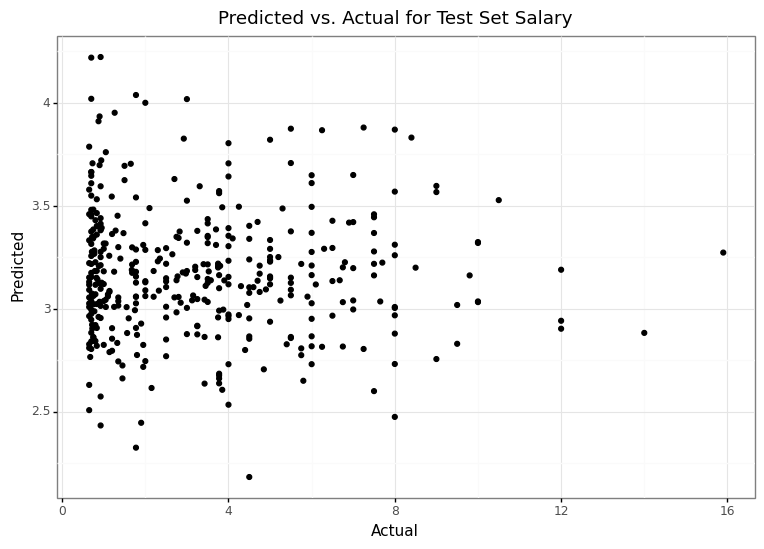

<ggplot: (351177524)>

In [44]:
check_preds = pd.DataFrame(zip(y_test, voting_test_preds), columns = ['true', 'preds'])

(
ggplot(check_preds, aes(x = 'true', y = 'preds')) + 
    geom_point() + 
    theme_bw() + 
    labs(x = "Actual", y = "Predicted", title = "Predicted vs. Actual for Test Set Salary")
)

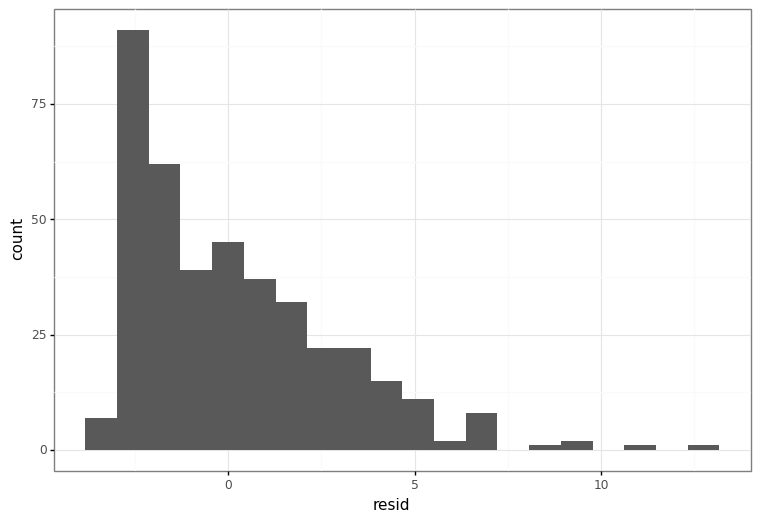

<ggplot: (348945996)>

In [45]:
resid = pd.DataFrame(zip(y_test, voting_test_preds), columns = ['actual', 'preds'])

resid = resid.assign(resid = resid.actual - resid.preds)

(
ggplot(resid, aes(x = "resid")) + 
    geom_histogram(bins = 20) + 
    theme_bw()
)


In [46]:
resid

,actual,preds,resid
0,2.5000,2.850365,-0.350365
1,0.8325,2.819602,-1.987102
2,7.0000,2.996323,4.003677
3,0.6500,3.116329,-2.466329
4,5.2000,3.250945,1.949055
...,...,...,...
393,1.0000,3.119876,-2.119876
394,6.0000,2.817453,3.182547
395,8.0000,3.008360,4.991640
396,1.1325,3.257267,-2.124767


In [47]:
y_train.mean()

# train_preds[1]

3.2081862028047468

In [48]:
test_mse = [mean_squared_error(preds, y_test) for preds in test_preds]
mod_names = [type(mod).__name__ for mod in best_models]
mse_df = pd.DataFrame(zip(mod_names, test_mse), columns = ['model', "mse"])

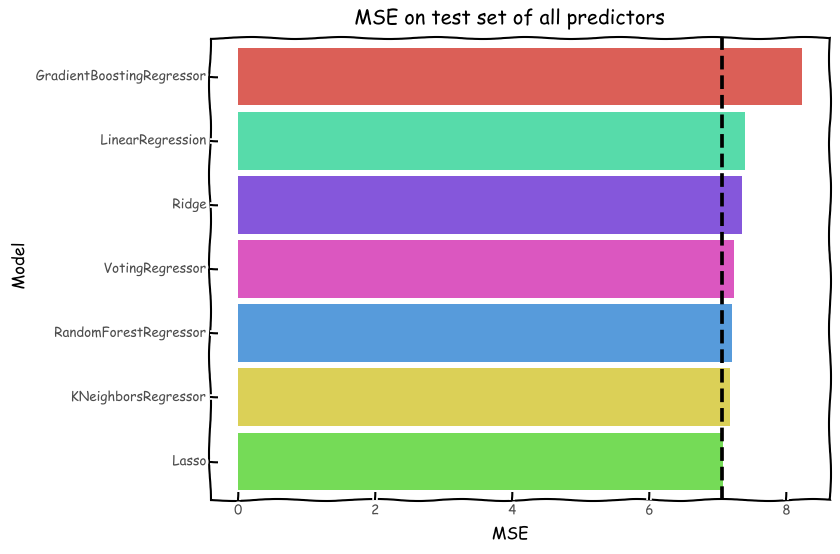

<ggplot: (348964283)>

In [49]:
mean_pred = np.mean((y_test - y_test.mean())**2)

mse_df = mse_df.sort_values(by='mse', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(mse_df['model'], categories=mse_df['model'])

# assign to a new column in the DataFrame
mse_df = mse_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = mse_df, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
#     lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "MSE", title = "MSE on test set of all predictors") +
    geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

In [50]:
train_mse = [mean_squared_error(preds, y_train) for preds in train_preds]
mod_names = [type(mod).__name__ for mod in best_models]
mse_train_df = pd.DataFrame(zip(mod_names, train_mse), columns = ['model', "mse"])

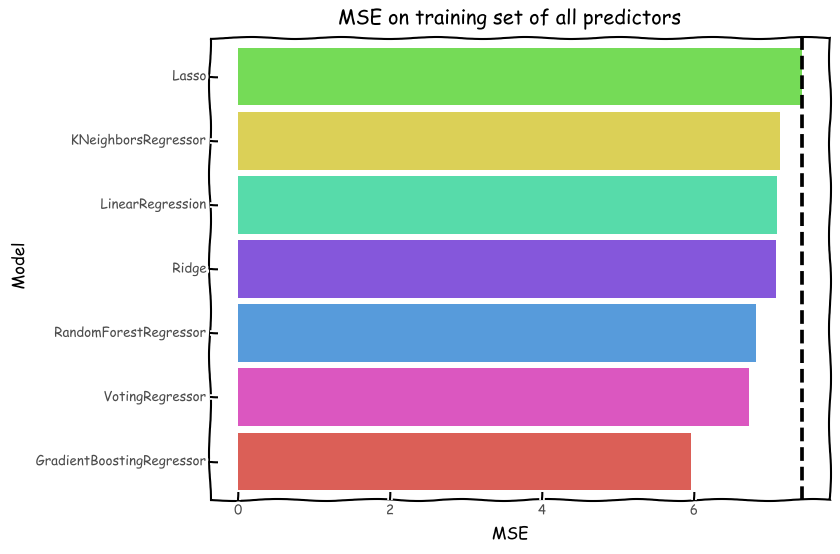

<ggplot: (345933469)>

In [51]:
mean_pred = np.mean((y_train - y_train.mean())**2)

mse_train_df = mse_train_df.sort_values(by='mse', ascending=True)
# sorting the variable importances for the plot
feature_cat = pd.Categorical(mse_train_df['model'], categories=mse_train_df['model'])

# assign to a new column in the DataFrame
mse_train_df = mse_train_df.assign(feature_cat = feature_cat)
plotnine.options.figure_size = (8, 6)

(
ggplot(data = mse_train_df, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
    geom_bar(stat = 'identity') + 
    theme_xkcd() + 
#     lims(y = (0, 1)) + 
    scale_fill_discrete(guide=False) +
    labs(x = "Model", y = "MSE", title = "MSE on training set of all predictors") +
    geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
    coord_flip()
)

In [52]:
# mse_df['type'] = "Test"

# mse_train_df['type'] = "Train"

# full_mse = pd.concat([mse_df, mse_train_df], axis='index', ignore_index=True)

# plotnine.options.figure_size = (12, 6)

# (
# ggplot(data = full_mse, mapping = aes(x = 'feature_cat', y = 'mse', fill = 'model')) + 
#     geom_bar(stat = 'identity') + 
#     theme_xkcd() + 
# #     lims(y = (0, 1)) + 
#     scale_fill_discrete(guide=False) +
#     labs(x = "Model", y = "MSE", title = "MSE on training set of all predictors") +
#     geom_hline(yintercept = mean_pred, size = 1.5, linetype = 'dashed') + 
#     coord_flip() + 
#     facet_grid(" ~ type")
# )

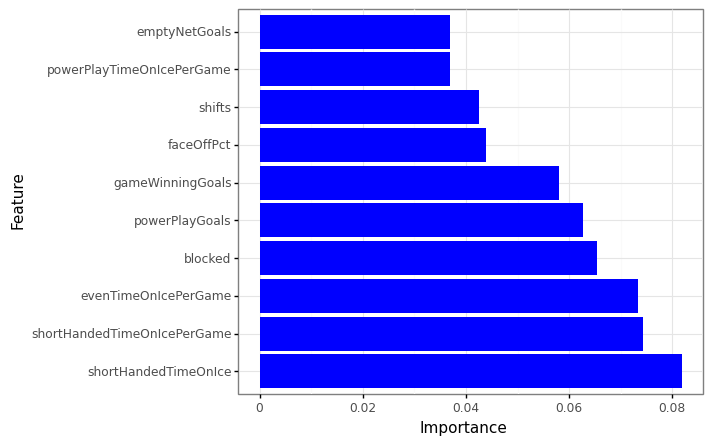

<ggplot: (348985579)>

In [53]:
# top 10 feature importances of the top Random Forest model
rf_features = pd.DataFrame(
    zip(transformer[0].named_transformers_['onehot'].get_feature_names(one_hot_columns).tolist() + num_scale_vars.to_list(), 
        best_models[1].feature_importances_), 
    columns = ['feature', 'importance'])
top_10_rf = rf_features.sort_values(by='importance', ascending=False)[:10]

# sorting the variable importances for the plot
feature_cat = pd.Categorical(top_10_rf['feature'], categories=top_10_rf['feature'])

# assign to a new column in the DataFrame
top_10_rf = top_10_rf.assign(feature_cat = feature_cat)

plotnine.options.figure_size = (6, 5)

(
ggplot(data = top_10_rf, mapping=aes(x = 'feature_cat', y = 'importance')) + 
    geom_bar(stat = 'identity', fill='blue') + 
    labs(x = "Feature", y = "Importance") + 
    coord_flip() + 
    theme_bw()
)